## Перцептрон


Как уже упоминалось, перцептрон позволяет решать **задачу бинарной классификации** — то есть распределять входные данные на два класса, условно названные **положительным** и **отрицательным**.

## Шаг 1 . 
### Подключаем библиотеки

In [87]:
import pylab
from matplotlib import gridspec
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

## Шаг 2 
### Простая задача

Для начала рассмотрим простую задачу, в которой у нас есть два входных признака. Например, в медицине можно классифицировать опухоли на доброкачественные и злокачественные в зависимости от их размера и возраста.

Мы создадим случайный набор данных для классификации, используя функцию `make_classification` из библиотеки SciKit Learn:

In [88]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # преобразовать начальные значения 0/1 в -1/1
X = X.astype(np.float32); Y = Y.astype(np.int32) # признаки — float, метки — int

#Разделим набор данных на обучающую и тестовую выборки
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Получаем первые четыре примера обучающих данных (признаки и метки).\n")
print("Признаки:\n",train_x[0:4])
print("Метки:\n",train_labels[0:4])

Получаем первые четыре примера обучающих данных (признаки и метки).

Признаки:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Метки:
 [-1 -1  1 -1]


## Шаг 3 
### Давайте также визуализируем набор данных с помощью функции plot_dataset :

/tmp/ipykernel_11138/1118413036.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


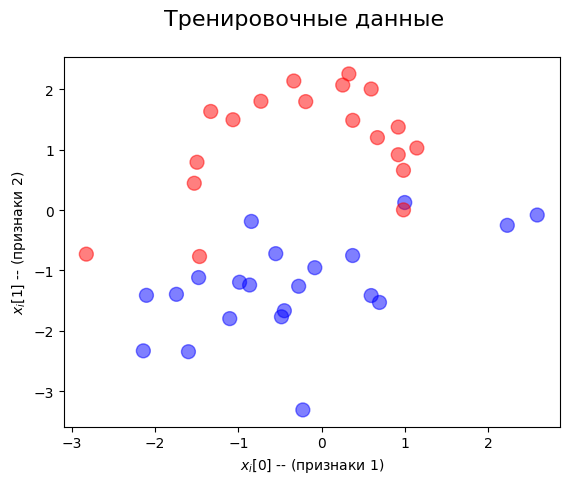

In [89]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (признаки 1)')
    ax.set_ylabel('$x_i[1]$ -- (признаки 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Тренировочные данные', train_x, train_labels)

## Перцептрон

Поскольку перцептрон используется для бинарной классификации, выходное значение для каждого входного вектора $x$ будет равно либо +1, либо -1, в зависимости от того, к какому классу принадлежит пример. Вычисление выхода происходит по следующей формуле:

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

где $\mathbf{w}$ - вес вектора, $f$ - шаг функции активации :
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

Однако, общий линейный модель должен также включать смещение, то есть в идеале нам нужно вычислить: $y$ as $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x}+\mathbf{b})$. Для упрощения модели мы можем исключить смещение, добавив дополнительную размерность к входным признакам, которая всегда будет равна 1:

In [90]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


## Шаг 4
### Алгоритм обучения

Для обучения перцептрона нам нужно найти такие веса ww, которые минимизируют ошибку. Ошибка определяется с использованием критерия **перцептрона**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$
 
  * $t_{n} \in \{-1, +1\}$ - для отрицательных и положительных обучающих примеров соответственно
  * $\mathcal{M}$ - набор неправильно классифицированных примеров
  
Мы будем использовать процесс **градиентного спуска**. Начав с некоторых случайных начальных весов $\mathbf{w}^{(0)}$, мы будем корректировать веса на каждом шаге обучения, используя градиент функции $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta\sum_{n \in \mathcal{M}}\mathbf{x}_{n} t_{n}$$

где $\eta$ - **Скорость обучение**, и $\tau\in\mathbb{N}$ - **Номер иттерации**.

Построим алгоритм в Python:

In [91]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    
    # Инициализация весов.
    # Мы инициализируем их значением 0 для простоты, но случайная инициализация также является хорошей идеей.
    
    weights = np.zeros((num_dims,1)) 
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10
    
    for i in range(num_iterations):
       
        ## Выбираем один положительный и один отрицательный пример
        
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            # положительный пример был классифицирован как отрицательный
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: 
            # отрицательный пример был классифицирован как положительный
            weights = weights - neg.reshape(weights.shape)
            
        #Периодически выводим текущую точность на всех примерах
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Итерация={}, положительный={}, отрицательный={}".format(i,pos_correct,neg_correct))

    return weights

Теперь давайте запустим обучение на нашем наборе данных:

In [92]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Итерация=0, положительный=0.42105263157894735, отрицательный=0.5238095238095238
Итерация=10, положительный=0.8421052631578947, отрицательный=0.9523809523809523
Итерация=20, положительный=0.9473684210526315, отрицательный=0.6190476190476191
Итерация=30, положительный=0.7894736842105263, отрицательный=1.0
Итерация=40, положительный=0.7368421052631579, отрицательный=0.9523809523809523
Итерация=50, положительный=0.7894736842105263, отрицательный=0.9523809523809523
Итерация=60, положительный=0.8947368421052632, отрицательный=0.9047619047619048
Итерация=70, положительный=0.8947368421052632, отрицательный=0.9047619047619048
Итерация=80, положительный=0.9473684210526315, отрицательный=0.9047619047619048
Итерация=90, положительный=0.8421052631578947, отрицательный=0.9523809523809523
[[-2.91416627  2.89136376  0.        ]]


Как видите, начальная точность составляет около 50%, но она быстро повышается до значений, близких к 90%.

Теперь давайте визуализируем, как классы разделяются. Наша функция классификации выглядит как $\mathbf{w}^Tx$, и она больше 0 для одного класса, а меньше 0 для другого. Таким образом, линия раздела классов определяется уравнением $\mathbf{w}^Tx = 0$. Поскольку у нас только две размерности  $x_0$  и $x_1$, уравнение для линии будет выглядеть как $w_0x_0+w_1x_1+w_2 = 0$ (не забывайте, что мы явно добавили дополнительную размерность $x_2=1$. Давайте построим эту линию.

In [93]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

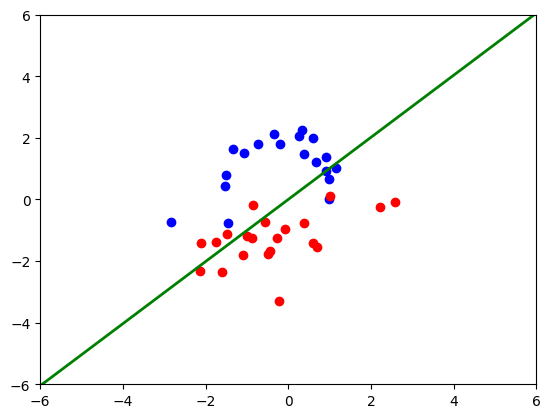

In [94]:
plot_boundary(pos_examples,neg_examples,wts)

## Шаг 5
### Оценка на тестовом наборе данных

В начале мы выделили часть данных для тестирования. Давайте посмотрим, насколько точно наш классификатор работает на этом тестовом наборе данных. Для этого мы также расширяем тестовый набор данных дополнительной размерностью, умножаем на матрицу весов и убеждаемся, что полученное значение имеет тот же знак, что и метка (+1 или -1). Затем мы складываем все булевы значения и делим на длину тестовой выборки, чтобы получить точность:

In [95]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

np.float64(0.9)

## Шаг 6
### Наблюдение за процессом обучения

Ранее мы видели, как точность изменяется во время обучения. Было бы полезно увидеть, как ведет себя линия раздела в процессе обучения. Код ниже визуализирует все на одном графике, и вы сможете использовать ползунок, чтобы «путешествовать во времени» через процесс обучения.

In [113]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]  # Количество признаков
    weights = np.zeros((num_dims, 1))  # Инициализация весов
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 15
    snapshots = []  # Список для хранения весов и точности
    
    for i in range(num_iterations):
        # Случайный выбор положительного и отрицательного примера
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        # Обработка положительного примера
        z = np.dot(pos, weights)
        if z < 0:
            weights = weights + pos.reshape(weights.shape)  # Обновление весов

        # Обработка отрицательного примера
        z = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)  # Обновление весов

        # Каждые `report_frequency` итераций собираем статистику
        if i % report_frequency == 0:
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)
            
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            
            # Добавляем информацию о весах и точности в список снимков
            snapshots.append((weights.flatten(), [(pos_correct + neg_correct) / 2.0, 0, 0]))

    return snapshots  # Возвращаем список снимков без преобразования в массив




snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples, neg_examples, snapshots, step):
    fig = pylab.figure(figsize=(10, 4))
    
    # Plotting the boundary in the first subplot
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    
    # Plotting the accuracy in the second subplot
    fig.add_subplot(1, 2, 2)
    accuracy_values = [snapshot[1][0] for snapshot in snapshots]  # Extract accuracy values
    pylab.plot(np.arange(len(accuracy_values)), accuracy_values)
    pylab.ylabel('Точность')
    pylab.xlabel('Итерация')
    pylab.plot(step, snapshots[step][1][0], "bo")  # Highlight the current step with a blue dot
    pylab.show()

def pl1(step): 
    plotit(pos_examples, neg_examples, snapshots, step)


In [114]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1,description='Шаг : '))

interactive(children=(IntSlider(value=0, description='Шаг : ', max=6), Output()), _dom_classes=('widget-intera…

<function __main__.pl1(step)>

## Шаг 7 
### Ограничения перцептрона

Как вы видели выше, перцептрон является **линейным классификатором**. Он может хорошо различать два класса, если они **линейно разделимы**, то есть могут быть разделены прямой линией. В противном случае процесс обучения перцептрона не будет сходиться.

Самым очевидным примером задачи, которую не может решить перцептрон, является так называемая **XOR задача**. Мы хотим, чтобы наш перцептрон выучил булеву функцию XOR, которая имеет следующую таблицу истинности:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 | 
| 1 | 1 | 0 |

Давайте попробуем это сделать! Мы вручную создадим все положительные и отрицательные обучающие примеры, а затем вызовем нашу функцию обучения, определенную выше:

In [98]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

In [115]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1 , description='Шаг : '))

interactive(children=(IntSlider(value=0, description='Шаг : ', max=6), Output()), _dom_classes=('widget-intera…

<function __main__.pl2(step)>

Как видно из графика выше, точность никогда не превышает 75%, потому что невозможно провести прямую линию таким образом, чтобы все примеры были классифицированы правильно.

Задача XOR является классическим примером ограничений перцептрона, и она была отмечена Марвином Минским и Сеймуром Папертом в 1969 году в их книге [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)). Это наблюдение ограничивало исследования в области нейронных сетей почти 10 лет, несмотря на то, что — и мы увидим это в следующем разделе нашего курса — многослойные перцептроны прекрасно решают такие задачи.

## Шаг 8
### Задача по сложней пример — MNIST

Хотя перцептрон не может решить задачу XOR, он может решить многие более сложные задачи, такие как распознавание рукописных символов.

Один из наборов данных, который часто используется при освоении машинного обучения, называется [MNIST](https://en.wikipedia.org/wiki/MNIST_database). Он был создан модифицированным Национальным институтом стандартов и технологий и содержит обучающий набор из 60000 рукописных цифр, собранных у около 250 студентов и сотрудников института. Также есть тестовый набор из 10000 цифр, собранных от других людей.

Все цифры представлены в виде изображений в градациях серого размера 28x28 пикселей.

Начнем с загрузки набора данных MNIST:

In [100]:
# Вам, нужно будет сначала скачать бинарный файл набора данных.  
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz  
# Потом исправьте ссылку на набор данных ниже вместо '../../mnist.pkl.gz', 'rb' впишите свой путь где хранится скаченный файл.

with gzip.open('../../mnist.pkl.gz', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle,encoding='latin1')
    print(type(MNIST))  # Должно вывести <class 'tuple'>
    print(len(MNIST))  # Узнаем, сколько элементов в кортеже
    print(MNIST)  # Посмотрим на содержимое кортежа


<class 'tuple'>
3
((array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8])), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([3, 8, 6, ..., 5, 6, 8])), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([7, 2, 1, ..., 4, 5, 6])))


Теперь давайте построим график набора данных:

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


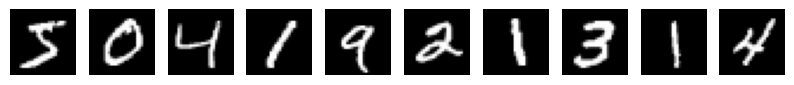

In [101]:
train_features = MNIST[0][0]  # Признаки (изображения) для обучения
train_labels = MNIST[0][1]    # Метки для обучения

# Проверим первые несколько элементов
print(train_features[0][130:180])  # Выведем часть первого изображения
print(train_labels[0])  # Выведем первую метку

# Нормализуем данные
features = train_features.astype(np.float32) / 256.0  # Нормализация в диапазон [0, 1]
labels = train_labels

# Отображаем первые 10 изображений
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(features[i].reshape(28, 28), cmap='gray')  # Переход от 1D массива к 2D
    ax.axis('off')  # Убираем оси
plt.show()

Поскольку перцептрон является бинарным классификатором, мы ограничим нашу задачу распознаванием только двух цифр. Функция ниже заполнил массивы положительных и отрицательных примеров двумя заданными цифрами (и также покажет примеры этих цифр для наглядности).

In [102]:
def set_mnist_pos_neg(positive_label, negative_label):
    # Извлекаем обучающие данные
    train_features = MNIST[0][0]  # Изображения
    train_labels = MNIST[0][1]    # Метки
    
    # Получаем индексы положительных и отрицательных примеров
    positive_indices = [i for i, label in enumerate(train_labels) if label == positive_label]
    negative_indices = [i for i, label in enumerate(train_labels) if label == negative_label]

    # Извлекаем изображения по индексам
    positive_images = train_features[positive_indices]
    negative_images = train_features[negative_indices]

    # Отображаем по одному изображению для положительного и отрицательного примера
    fig = plt.figure(figsize=(8, 4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(positive_images[0].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Положительная метка: {positive_label}')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(negative_images[0].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Отрицательная метка: {negative_label}')
    
    plt.show()
    
    return positive_images, negative_images

Мы начнем с попытки классифицировать между 0 и 1.

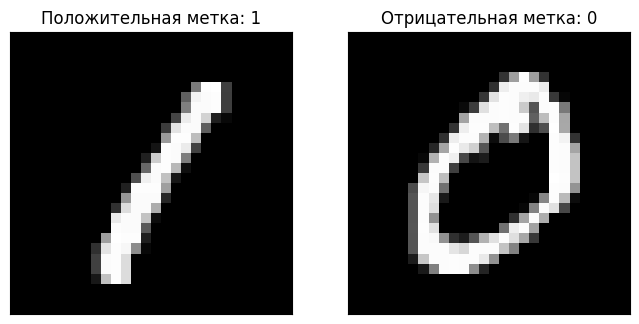

In [103]:
pos1,neg1 = set_mnist_pos_neg(1,0)

In [111]:
def plotit2(snapshots_mn, step):
    fig = plt.figure(figsize=(10, 4))

    # Изображение на первом подграфике
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest', cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(ax.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest', cmap='gray'))

    # График на втором подграфике
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0, 1])
    accuracies = [snapshot[1][0] for snapshot in snapshots_mn]  # Извлекаем точность из каждого снимка
    ax.plot(np.arange(len(snapshots_mn)), accuracies)  # Теперь используем правильную индексацию
    ax.plot(step, accuracies[step], "bo")  # Отметка текущего шага
    plt.show()

# Функции для визуализации через шаг
def pl3(step): 
    plotit2(snapshots_mn, step)

def pl4(step): 
    plotit2(snapshots_mn2, step)


In [112]:
snapshots_mn = train_graph(pos1, neg1, 1000)    
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1, step=1, description="Step"))

interactive(children=(IntSlider(value=0, description='Step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl3(step)>

Пожалуйста, обратите внимание, как точность быстро увеличивается до почти 100%.

Теперь переместите ползунок в положение ближе к концу обучения и посмотрите на матрицу весов, отображенную слева. Эта матрица поможет вам понять, как работает перцептрон. Вы можете увидеть высокие значения весов в центре поля, которые соответствуют пикселям, которые обычно присутствуют на цифре 1, и низкие отрицательные значения по краям, где находятся части цифры 0. Таким образом, если перцептрону подается цифра 1, центральная часть её будет умножаться на высокие значения, что приведет к положительному результату. Напротив, когда перцептрон видит 0, соответствующие пиксели будут умножаться на отрицательные числа.

> Вы можете заметить, что если мы дадим нашему перцептрону цифру 1, немного смещенную по горизонтали, так что её пиксели займут место, где находятся вертикальные части цифры 0, это может привести к неправильному результату. Поскольку природа нашего набора данных MNIST такова, что все цифры центрированы и правильно расположены, перцептрон полагается на это для различения цифр.

Теперь давайте попробуем другие цифры:

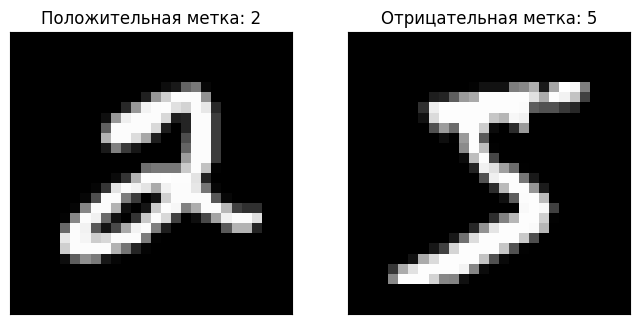

In [106]:
pos2,neg2 = set_mnist_pos_neg(2,5)

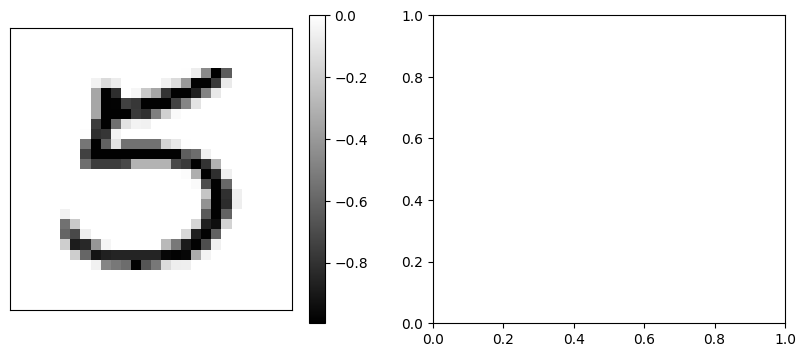

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl4(step)>

In [107]:
snapshots_mn2 = train_graph(pos2,neg2,1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

## Шаг 9
### Заметки

По какой-то причине цифры 2 и 5 не так легко разделимы. Несмотря на то, что мы получаем относительно высокую точность (более 85%), мы явно видим, что перцептрон прекращает обучение на каком-то этапе.

Чтобы понять, почему это происходит, мы можем попытаться использовать [Метод Главных Компонент (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). Это метод машинного обучения, который используется для уменьшения размерности входного набора данных таким образом, чтобы достичь наилучшей разделимости между классами.

В нашем случае входное изображение имеет 784 пикселя (входные признаки), и мы хотим использовать PCA, чтобы уменьшить количество параметров до всего лишь 2, чтобы мы могли отобразить их на графике. Эти два параметра будут линейной комбинацией исходных признаков, и мы можем рассматривать эту процедуру как "поворот" нашего исходного 784-мерного пространства и наблюдение его проекции в 2D-пространство, пока не получим лучший вид, который разделяет классы.

In [108]:
from sklearn.decomposition import PCA

def pca_analysis(positive_label, negative_label):
    positive_images, negative_images = set_mnist_pos_neg(positive_label, negative_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(n_components=2)
    mypca.fit(M)
    
    pos_points = mypca.transform(positive_images[:200])
    neg_points = mypca.transform(negative_images[:200])

    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

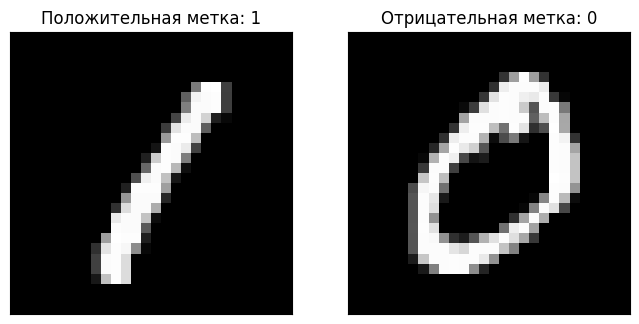

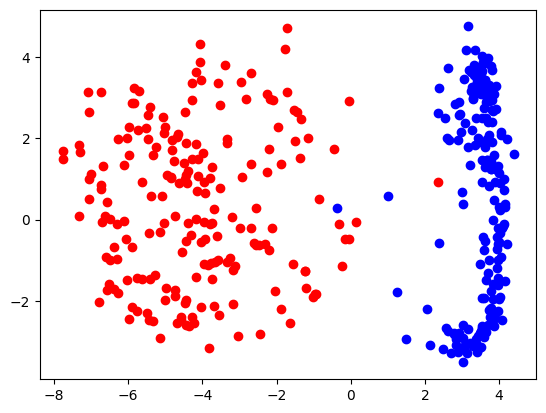

In [109]:
pca_analysis(1,0)

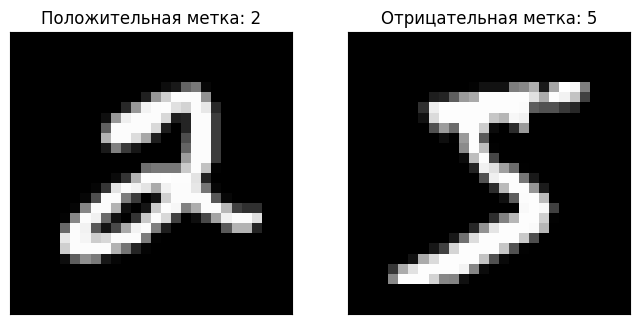

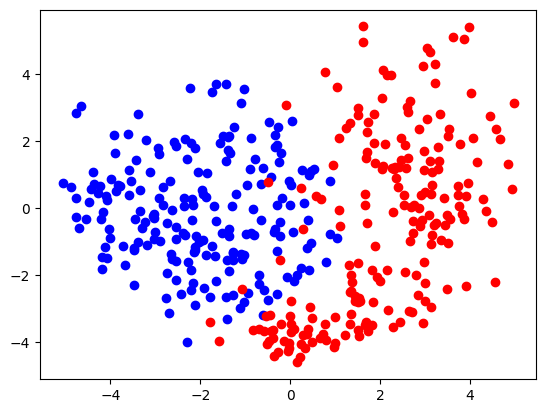

In [110]:
pca_analysis(2,5)

Как видно, цифры 0 и 1 можно четко разделить прямой линией. Это указывает на то, что в исходном 784-мерном пространстве точки, соответствующие цифрам, также линейно разделимы. В случае с цифрами 2 и 5 мы не можем найти подходящую проекцию, которая четко разделит цифры, и, следовательно, появляются ошибки классификации.

> Позже в курсе мы научимся создавать нелинейные классификаторы с использованием нейронных сетей и решать проблему неправильного выравнивания цифр. Очень скоро мы достигнем точности классификации MNIST более 99%, классифицируя их на 10 различных классов.

## Основные выводы

 * Мы узнали о самой простой архитектуре нейронной сети — однослойном перцептроне.
 * Мы реализовали перцептрон "вручную", используя простую процедуру обучения на основе градиентного спуска.
 * Несмотря на свою простоту, однослойный перцептрон может решать достаточно сложные задачи распознавания рукописных цифр.
 * Однослойный перцептрон является линейным классификатором и, таким образом, обладает такой же классификационной мощностью, как и логистическая регрессия.
 * В пространстве признаков перцептрон может разделять два класса входных данных с помощью гиперплоскости.